In [219]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [220]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005

In [241]:
## Fitz Hugh Nagumo Params

size = 10 #0 #0  # size of the 2D grid
dx = 2. / size  # space step

T = 12. #20.0  # total time
dt = .001  # time step
n = int(T / dt)  # number of iterations


In [242]:
U = np.random.rand(size, size)
V = np.random.rand(size, size)
U_init = U
V_init = V

In [243]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

In [244]:
def show_patterns(U, ax=None):
    ax.imshow(U, cmap=plt.cm.copper,
              interpolation='bilinear',
              extent=[-1, 1, -1, 1])
    ax.set_axis_off()

In [245]:
def turing_pde(U, V, dt, parameters):
        deltaU = laplacian(U)
        deltaV = laplacian(V)
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        # Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
        # Vc + dt * (b * deltaV + Uc - Vc) / tau
        U[1:-1, 1:-1], V[1:-1, 1:-1] = fitzHughNagumo(Uc, Vc, deltaU, deltaV, dt, parameters)
        return U, V

In [246]:
def solve_numerically(U_in, V_in, n, dt, parameters, plot=False):
    U = copy.deepcopy(U_in)
    V = copy.deepcopy(V_in)
    if plot: 
        fig, axes = plt.subplots(3, 3, figsize=(8, 8))
        step_plot = n // 9
    for i in range(n):
        # We compute the Laplacian of u and v.
        # deltaU = laplacian(U)
        # deltaV = laplacian(V)
        # We take the values of u and v inside the grid.
        # Uc = U[1:-1, 1:-1]
        # Vc = V[1:-1, 1:-1]
        # We update the variables.
        # U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        #     Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
        #     Vc + dt * (b * deltaV + Uc - Vc) / tau
        # U[1:-1, 1:-1], V[1:-1, 1:-1] = turing_pde(U, V, dt, a, b, k, tau)
        U, V = turing_pde(U, V, dt, parameters)
        # Neumann conditions: derivatives at the edges
        # are null.
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]
        
        if plot and i % step_plot == 0 and i < 9 * step_plot:
            ax = axes.flat[i // step_plot]
            show_patterns(U, ax=ax)
            ax.set_title(f'$t={i * dt:.2f}$')
    
    return U, V

In [247]:
def fitzHughNagumo(Uc, Vc, deltaU, deltaV, dt, parameters):
    (a, b, k, tau) = parameters
    return \
        Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
        Vc + dt * (b * deltaV + Uc - Vc) / tau

<Figure size 432x288 with 0 Axes>

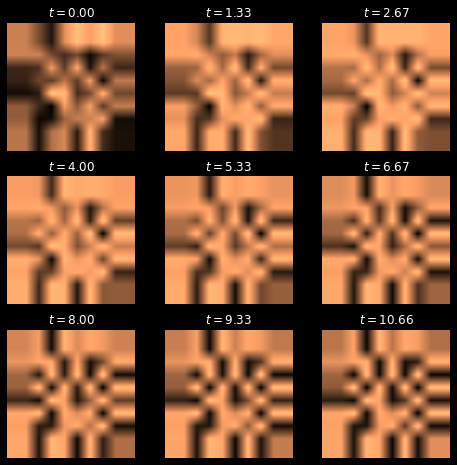

In [248]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005

parameters = (a, b, k, tau)

# for a in np.arange(0.5e-4, 5.5e-4, 0.5e-4):               # increases in a decrease spatial frequency
# for b in np.arange(1e-3, 8e-3, 1e-3):                     # increases in b accelerate pattern formation
# for k in np.arange(-.1, 1, 0.1):                            # small variations dont change much, large variations change pattern type completely
# for tau in np.arange(0.1, 3., 0.3):                       # tau must be greater 0., large tau makes pattern very diffuse
plt.figure()
U, V = solve_numerically(U_init, V_init, n, dt, parameters, plot=True)

In [249]:
def likelihood(samples, proposed_solution, var=0.1):
    p = (1/np.sqrt(2* np.pi * var**2)) * np.exp(-np.power(samples - proposed_solution, 2) / (2 * var**2))
    # print(f'Max:{np.min(p)} , Min: {np.max(p)})')
    return np.prod(p)

In [250]:
def log_likelihood(samples, proposed_solution, var=0.1):
    log_p = -np.power(samples - proposed_solution, 2) / (2 * var**2)
    return np.sum(log_p)

In [251]:
def prior(params): 
    return 1.

In [252]:
def proposed_solution(U, V, n, dt, parameters, fourier=False):
    U, V = solve_numerically(U, V, n, dt, parameters)
    if fourier:
        U = np.fft.fft2(U)
        V = np.fft.fft2(V)
    return U, V

In [253]:
def posterior(samples, parameters):
    # (a, b, k, tau) = parameters
    proposed_U, proposed_V = proposed_solution(U_init, V_init, n, dt, parameters, fourier=True)
    l = likelihood(samples, np.concatenate((proposed_U, proposed_V)))
    # print(f'Likelihood: {l}')
    p = prior(parameters)
    return l * p

In [254]:
def log_posterior(samples, parameters):
    proposed_U, proposed_V = proposed_solution(U_init, V_init, n, dt, parameters)
    l = log_likelihood(samples, np.concatenate((proposed_U, proposed_V)))
    # print(f'Likelihood: {l}')
    # p = prior(parameters)
    return l

In [255]:
def proposal_parameters(current_params, var=0.25):
    (a, b, k, tau) = current_params
    new_a = np.random.normal(a, 0.5e-4)
    new_b = np.random.normal(b, 1e-3)
    new_k = np.random.normal(k, 0.1)
    new_tau = np.random.normal(tau, 0.3)
    return (new_a, new_b, new_k, new_tau)  

In [256]:
def accept_reject_RWM(samples, current_params, proposed_params):
    # prop_post = posterior(samples, proposed_params)
    # current_post = posterior(samples, current_params)
    # ratio = prop_post / current_post

    log_prop_post = log_posterior(samples, proposed_params)
    log_current_post = log_posterior(samples, current_params)
    diff = log_prop_post - log_current_post
    # print(f'Proposed posterior: {log_prop_post}')
    # print(f'Current posterior: {log_current_post}')
    # if ratio > np.random.uniform():
    #     print(f'switched for ratio: {ratio}')
    #     return proposed_params
    # else: 
    #     return current_params


    if diff > np.log(np.random.uniform()):
        print(f'switched for ratio: {diff}')
        return proposed_params
    else: 
        return current_params

In [257]:
def RWM_step(samples, current_params):
    proposed_params = proposal_parameters(current_params)
    new_params = accept_reject_RWM(samples, current_params, proposed_params)
    return new_params


In [262]:
iteration_nr = 100

a_initial = np.random.uniform(0.5e-4, 5.5e-4)
b_initial = np.random.uniform(1e-3, 8e-3)
k_initial = np.random.uniform(-.1, 1)
tau_intial = np.random.uniform(0.1, 3.)

current_params = (a_initial, b_initial, k_initial, tau_intial)

print(f'Initial params are: {current_params}')
a_vec = []
b_vec = []
k_vec = []
tau_vec = []

for i in tqdm(range(iteration_nr)): 
    a_vec.append(current_params[0])
    b_vec.append(current_params[1])
    k_vec.append(current_params[2])
    tau_vec.append(current_params[3])

    # current_params = RWM_step(np.concatenate((U, V)), current_params)
    current_params = RWM_step(np.concatenate((np.fft.fft2(U), np.fft.fft2(V))), current_params)
    

current_params


  0%|          | 0/100 [00:00<?, ?it/s]

Initial params are: (0.0005378594647317028, 0.002307446083956003, 0.9259538842617269, 0.9266018916569609)


  1%|          | 1/100 [00:00<01:23,  1.19it/s]

switched for ratio: (294.1701421845937+1.2058656011504354e-05j)


  3%|▎         | 3/100 [00:02<01:22,  1.18it/s]

switched for ratio: (363.9081514288846-6.052459866623394e-07j)


  4%|▍         | 4/100 [00:03<01:21,  1.18it/s]

switched for ratio: (248.99493508751038+3.4853860597650055e-06j)


  6%|▌         | 6/100 [00:05<01:18,  1.19it/s]

switched for ratio: (720.6883325663221-3.5793118513538502e-06j)


 10%|█         | 10/100 [00:08<01:15,  1.20it/s]

switched for ratio: (509.031079021428-9.596811651135795e-06j)


 11%|█         | 11/100 [00:09<01:14,  1.20it/s]<ipython-input-247-d1cb3b95a22c>:4: RuntimeWarning: overflow encountered in power
  Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
<ipython-input-247-d1cb3b95a22c>:4: RuntimeWarning: invalid value encountered in add
  Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
<ipython-input-247-d1cb3b95a22c>:5: RuntimeWarning: invalid value encountered in add
  Vc + dt * (b * deltaV + Uc - Vc) / tau
 13%|█▎        | 13/100 [00:10<01:12,  1.21it/s]

switched for ratio: (1287.7693969392567-0.6857527811462205j)


 15%|█▌        | 15/100 [00:12<01:10,  1.21it/s]

switched for ratio: (7757.0402159683+535.4830686924183j)


 25%|██▌       | 25/100 [00:20<01:02,  1.21it/s]<ipython-input-243-4fa2c5342cc4>:7: RuntimeWarning: invalid value encountered in add
  return (Ztop + Zleft + Zbottom + Zright -
 32%|███▏      | 32/100 [00:26<00:56,  1.20it/s]<ipython-input-247-d1cb3b95a22c>:4: RuntimeWarning: invalid value encountered in subtract
  Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
 35%|███▌      | 35/100 [00:29<00:53,  1.21it/s]<ipython-input-243-4fa2c5342cc4>:7: RuntimeWarning: invalid value encountered in subtract
  return (Ztop + Zleft + Zbottom + Zright -
 46%|████▌     | 46/100 [00:38<00:44,  1.20it/s]

switched for ratio: (588.661836686806-473.36134854554894j)


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


(0.0006327112472459748,
 0.00615296209249788,
 0.038916625564725596,
 0.08802998756842753)

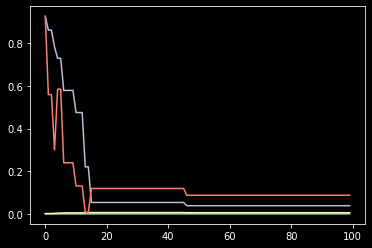

In [263]:
plt.plot(a_vec, label='a')
plt.plot(b_vec, label='b')
plt.plot(k_vec, label='k')
plt.plot(tau_vec, label='tau')

<Figure size 432x288 with 0 Axes>

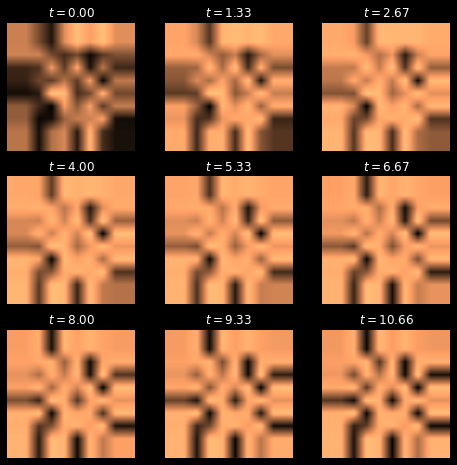

In [264]:
plt.figure()
U, V = solve_numerically(U_init, V_init, n, dt, current_params, plot=True)